# Gaussian Mixture Model (GMM)

In [1]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

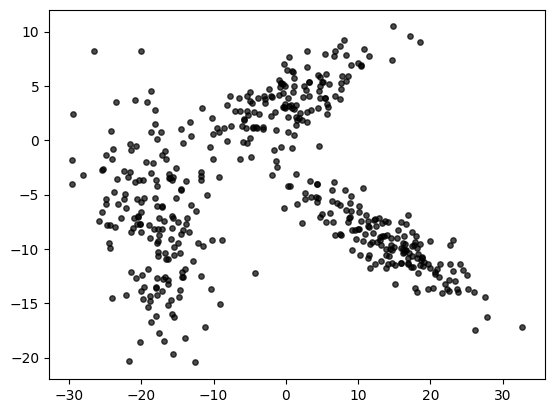

In [2]:
X1 = make_blobs(n_samples=170, random_state=40, centers=[[-9, -5.5]], cluster_std=2)[0]
X2 = make_blobs(n_samples=170, random_state=50, centers=[[-4.5, 0]], cluster_std=1.5)[0]
X3 = make_blobs(n_samples=130, random_state=60, centers=[[2, 2]], cluster_std=1.3)[0]
transformation1 = [[2, -1], [0, 3]]
X1 = np.dot(X1, transformation1)
transformation2 = [[-3, 2], [4, -1]]
X2 = np.dot(X2, transformation2)
transformation3 = [[-3, 0], [3.5, 2]]
X3 = np.dot(X3, transformation3)
X = np.concatenate((X1, X2, X3))

plt.scatter(X[:, 0], X[:, 1], c='k', s=15, alpha=0.7)
plt.show()

## Scikit-Learn

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
gm = GaussianMixture(n_components=3, n_init=10)
labels = gm.fit_predict(X)

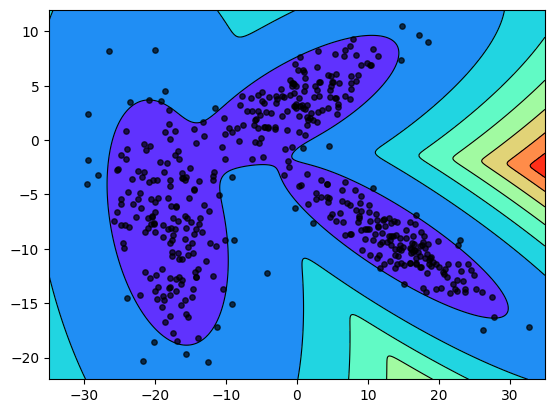

In [5]:
xx, yy = np.meshgrid(np.linspace(-35, 35, 700), np.linspace(-22, 12, 340))
z = -gm.score_samples(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, z, cmap=plt.cm.rainbow)
plt.contour(xx, yy, z, colors=['k'], linewidths=0.8)
plt.scatter(X[:, 0], X[:, 1], c='k', s=15, alpha=0.7)
plt.show()

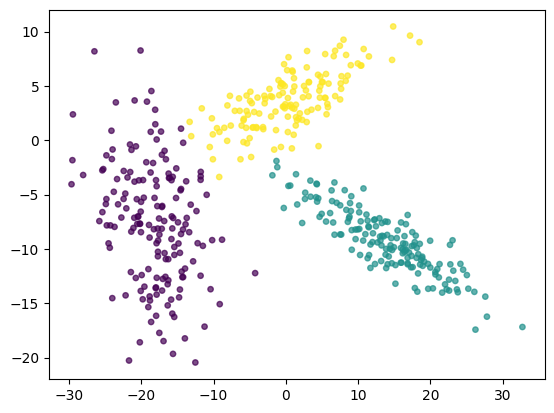

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, alpha=0.7)
plt.show()

## Implementation

to implement GMM, we use a model named **Expectation-Maximization (EM)**; EM is very similar to *K-Means*; in other words, EM is a generalization of K-Means

K-Means is only based on centroids, but GMM considers *centers* and each *cluster's size, shape and orientation*; by the way, GMM outputs *probabilities* of each instance being contained in each of the clusters (*soft clustering*)

---
notaion below considers that $X$ is $m$x$n$ matrix and the number of clusters is $k$

### Maximization Step:
in this step, **weights, means and covariance matrices are calculated** based on probabilites
### weight: $w_j = \dfrac{\sum_{i=1}^m p_{ij}}{\sum_{j=1}^k \sum_{i=1}^m p_{ij}}$
### mean: $\mu_j = \dfrac{\sum_{i=1}^m [p_{ij} x_i]}{\sum_{i=1}^m p_{ij}}$
### covariance matrix: $\Sigma_j = \dfrac{\sum_{i=1}^m p_{ij} (x_i - \mu_j) (x_i - \mu_j)^T}
{\sum_{i=1}^m p_{ij}}$
---
### Expectation Step: 
in this step, **probabilities are updated** with respect to wights, means and covariance matrices
### Gaussian estimation formula: $N(x, \mu, \Sigma) = \dfrac{1}{\sqrt{(2\pi)^n |\Sigma|}}
\exp(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu))$
### Probability of $x_i$ in Gaussian: $p_{ij} = \dfrac{N_j(x_i) w_{j}}{\sum_{j=1}^k N_j(x_i) w_{j}}$
---
### Convergance:
**log-likelihood** is calculated after each pair of above steps; when it's value changes less than a threshold, the algorithm stops
### log-likelihood: $L(x_1, ..., x_n) = \sum_{i=1}^m log_2 (max(p_i))$

In [10]:
class GaussianMixtureModel:
    def __init__(self, n_clusters, n_init=10):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.weights = None
        self.means = None
        self.covariances = None
        self.probabilities = None
        
    def fit(self, X):
        n_samples, n_features = X.shape
        self.weights = np.zeros((self.n_clusters,))
        self.means = np.zeros((self.n_clusters, n_features))
        self.covariances = np.zeros((self.n_clusters, n_features, n_features))
        best_weights, best_means, best_covariances = None, None, None
        
#         for i in range(self.n_init):
        self._initialize_probabilities(n_samples)
        likelihood = 0
        
        while True:
            self.weights, self.means, self.covariances = self._calculate_features(X, self.probabilities)
            self.probabilities = self._calculate_probabilities(X, self.weights, self.means, self.covariances)
            new_likelihood = self._log_likelihood(X)
            
            if np.abs(new_likelihood - likelihood) <= 1e-3: break
            else: likelihood = new_likelihood
#             inertia = self._inertia(X)
#             if inertia < least_inertia:
#                 least_inertia = inertia
#                 best_centroids = self.centroids
        
#         self.weights = best_weights
#         self.means = best_means
#         self.covariances = best_covariances
#         self.probabilities = self._label_instances(X, self.centroids)
                
     
    def _initialize_probabilities(self, n_samples):
        self.probabilities = np.zeros((n_samples, self.n_clusters))
        for i in range(n_samples):
            self.probabilities[i, np.random.randint(0, self.n_clusters)] = 1
        
        
    def _log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = np.sum(np.log2(np.max(self.probabilities, axis=1)))
        return log_likelihood
    
    
    def _calculate_features(self, X, probs):
        n_samples = X.shape[0]
        
        probs_sum = np.sum(probs)
        new_wights = np.array([np.sum(probs[:, j]) / probs_sum for j in range(self.n_clusters)])
        
        new_means = np.array([np.sum([probs[i, j] * X[i] for i in range(n_samples)], axis=0)
                              / np.sum(probs[:, j]) for j in range(self.n_clusters)])
        
        new_covariances = np.array([np.sum([probs[i, j] * (X[i] - new_means[j]).reshape(-1, 1)
                                    .dot((X[i] - new_means[j]).reshape(1, -1)) for i in range(n_samples)], axis=0) 
                                    / np.sum(probs[:, j]) for j in range(self.n_clusters)])
        
        return new_wights, new_means, new_covariances
            
            
    def _calculate_probabilities(self, X, weights, means, covariances):
        n_samples, n_features = X.shape
        new_probs = np.zeros((n_samples, self.n_clusters))
        
        for i in range(n_samples):
            gaussian_weight = np.array([self._gaussian(n_features, X[i], means[j], covariances[j]) * weights[j]
                                          for j in range(self.n_clusters)])
            
            new_probs[i] = gaussian_weight / np.sum(gaussian_weight)
        return new_probs
    
    
    def _gaussian(self, n_features, x, mean, covariance):
        coefficient = 1 / np.sqrt(((2 * np.pi) ** n_features) * np.linalg.det(covariance))
        value = np.exp(-0.5 * (x - mean).reshape(1, -1).dot(np.linalg.pinv(covariance)).dot((x - mean).reshape(-1, 1)))
        return coefficient * value.reshape(1,)[0]

    
#     def predict(self, X):
#         y_pred = np.array([np.argmax(probs[j]) for j in range(self.n_clusters)])
#         return y_pred

    
    def fit_predict(self, X):
        self.fit(X)
        labels = np.argmax(self.probabilities, axis=1)
        return labels

In [11]:
gm = GaussianMixtureModel(n_clusters=3)
labels = gm.fit_predict(X)

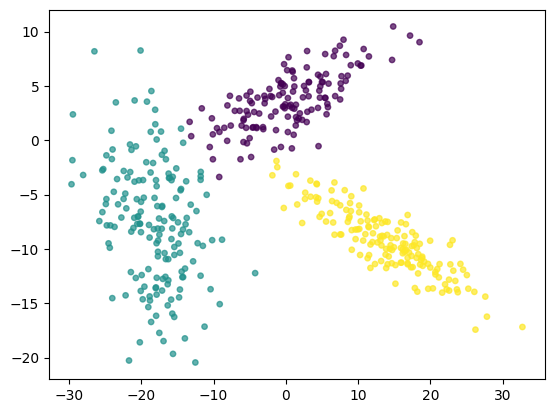

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, alpha=0.7)
plt.show()